**Intrusion Detection System**

**Phase - I: Model Training**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CICIDS2017_sample.csv')

In [4]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df.shape

(56661, 78)

In [6]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

In [7]:
df['Label'].value_counts()

,count
Label,
BENIGN,22731
DoS,19035
PortScan,7946
BruteForce,2767
WebAttack,2180
Bot,1966
Infiltration,36


Label Encoding to covert categorical data to numerical

In [8]:
# Step 1: Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [9]:
# Step 2: Split features and labels
X = df.drop(['Label'], axis=1).values
y = df['Label'].values

In [10]:
# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, stratify=y, random_state=0
)

In [11]:
# Step 4: Apply SMOTE ONLY to class 4, up to 1500 samples
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy={4: 1500})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [12]:
pd.Series(y_train).value_counts()

,count
0,18184
3,15228
5,6357
2,2213
6,1744
1,1573
4,1500


**Model Training**

Training 3 base learners

Accuracy of DT: 0.9955881055325156
Precision of DT: 0.9955919394899142
Recall of DT: 0.9955881055325156
F1-score of DT: 0.9955847223935529
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       1.00      1.00      1.00     11333



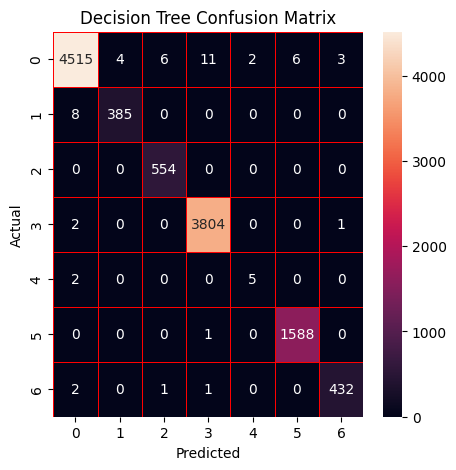

['decision_tree_model.pkl']

In [13]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)

dt.fit(X_train,y_train)

dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test

print('Accuracy of DT: '+ str(dt_score))

dt_precision,dt_recall,dt_fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(dt_precision)))
print('Recall of DT: '+(str(dt_recall)))
print('F1-score of DT: '+(str(dt_fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('dt_confusion_matrix.png')  # Save the plot
plt.show()
plt.close()

import joblib
joblib.dump(dt, 'decision_tree_model.pkl')

In [14]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9949704403070678
Precision of RF: 0.9949587060640095
Recall of RF: 0.9949704403070678
F1-score of RF: 0.9949578553649047
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.98      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       0.99      0.99      0.99     11333



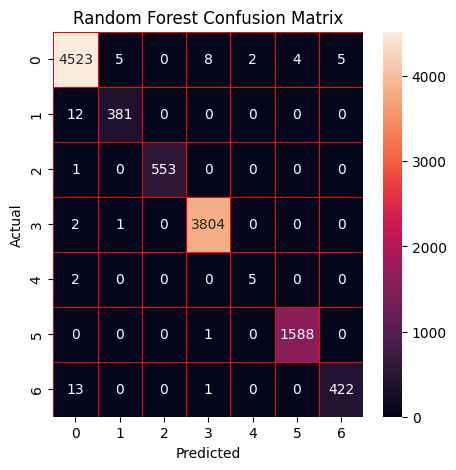

['random_forest_model.pkl']

In [15]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)

rf.fit(X_train,y_train)

rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test

print('Accuracy of RF: '+ str(rf_score))

rf_precision,rf_recall,rf_fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(rf_precision)))
print('Recall of RF: '+(str(rf_recall)))
print('F1-score of RF: '+(str(rf_fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('rf_confusion_matrix.png')  # Save the plot
plt.show()
plt.close()

joblib.dump(rf, 'random_forest_model.pkl')

In [16]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of XGBoost: 0.9941762993029207
Precision of XGBoost: 0.9941667457012846
Recall of XGBoost: 0.9941762993029207
F1-score of XGBoost: 0.9941579573784806
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      0.99      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



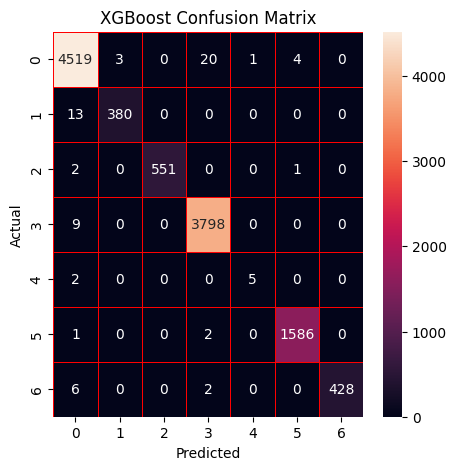

['xgboost_model.pkl']

In [17]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)

xg.fit(X_train,y_train)

xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test

print('Accuracy of XGBoost: '+ str(xg_score))

xgb_precision,xgb_recall,xgb_fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(xgb_precision)))
print('Recall of XGBoost: '+(str(xgb_recall)))
print('F1-score of XGBoost: '+(str(xgb_fscore)))

print(classification_report(y_true,y_predict))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('xgb_confusion_matrix.png')
plt.show()
plt.close()

joblib.dump(xg, 'xgboost_model.pkl')

In [18]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

Saving Results

In [19]:
results = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [dt_score, rf_score, xg_score],
    'Precision': [dt_precision, rf_precision, xgb_precision],
    'Recall': [dt_recall, rf_recall, xgb_recall],
    'F1-score': [dt_fscore, rf_fscore, xgb_fscore]
}

df_results = pd.DataFrame(results)
df_results.to_csv('model_results_phase1.csv', index=False)

**Phase - II: Feature Selection & Model Training**

In [20]:
#Get feature importances
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
xgb_feature = xg.feature_importances_

In [21]:
# Average the importance values
avg_feature = (dt_feature + rf_feature + xgb_feature) / 3

In [22]:
# Get feature names
feature_names = df.drop(['Label'], axis=1).columns.values

In [23]:
# Combine and sort by importance
f_list = sorted(zip(map(lambda x: round(x, 6), avg_feature), feature_names), reverse=True)

In [24]:
print("Features sorted by importance:")
for importance, name in f_list:
    print(f"{name}: {importance}")

Features sorted by importance:
Bwd Packet Length Std: 0.147187
Bwd Packet Length Min: 0.095712
Average Packet Size: 0.077307
Init_Win_bytes_backward: 0.058968
Bwd Packets/s: 0.056671
Init_Win_bytes_forward: 0.040494
Bwd Packet Length Mean: 0.039057
PSH Flag Count: 0.025897
Packet Length Variance: 0.024667
Fwd Header Length: 0.024164
Bwd Header Length: 0.023912
Packet Length Std: 0.022019
Total Length of Fwd Packets: 0.021785
Packet Length Mean: 0.021398
Flow IAT Std: 0.016884
act_data_pkt_fwd: 0.016597
Avg Bwd Segment Size: 0.016457
Max Packet Length: 0.015528
min_seg_size_forward: 0.01295
Fwd Header Length.1: 0.012452
Bwd Packet Length Max: 0.012049
Fwd IAT Min: 0.010945
Subflow Bwd Bytes: 0.010856
Fwd PSH Flags: 0.010211
Fwd IAT Total: 0.009514
Idle Max: 0.009397
Fwd IAT Max: 0.008786
Total Length of Bwd Packets: 0.008409
Bwd IAT Min: 0.008316
Total Fwd Packets: 0.008245
Fwd IAT Mean: 0.008173
Bwd IAT Total: 0.007812
Flow IAT Min: 0.00777
Fwd Packet Length Max: 0.006989
Subflow Fwd B

In [25]:
len(f_list)

77

In [26]:
# Select features cumulatively up to 90% importance
selected_features = []
importance_sum = 0.0

for importance, name in f_list:
    importance_sum += importance
    selected_features.append(name)
    if importance_sum >= 0.9:
        break

print(f"\nSelected top {len(selected_features)} features.")


Selected top 35 features.


In [27]:
# New feature-reduced X
X_reduced = df[selected_features].values

In [28]:
#Train-Test Split on Reduced Features
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y, train_size=0.8, random_state=0, stratify=y
)

In [29]:
X_train_red.shape

(45328, 35)

In [30]:
pd.Series(y_train_red).value_counts()

,count
0,18184
3,15228
5,6357
2,2213
6,1744
1,1573
4,29


In [48]:
#Oversampling by SMOTE
from imblearn.over_sampling import SMOTE

# Only oversample class 4 (e.g., Infiltration) to 1500 samples
smote = SMOTE(sampling_strategy={4: 1500}, random_state=0)

X_train_res, y_train_res = smote.fit_resample(X_train_red, y_train_red)

# Check new class distribution
print(pd.Series(y_train_res).value_counts())

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64


Machine learning model training after feature selection

DT Accuracy: 0.995499867643166
DT Precision: 0.995503707282571
DT Recall: 0.995499867643166
DT F1-score: 0.9954967135132968
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       1.00      1.00      1.00     11333



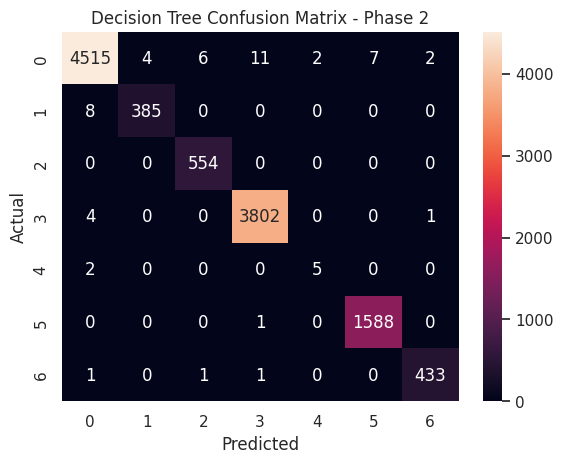

['phase2_decision_tree_model.pkl']

In [49]:
dt2 = DecisionTreeClassifier(random_state=0)
dt2.fit(X_train_res, y_train_res)

y_pred_dt = dt2.predict(X_test_red)
dt2_score = dt2.score(X_test_red, y_test_red)
dt2_precision, dt2_recall, dt2_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_dt, average='weighted')

print("DT Accuracy:", dt2_score)
print("DT Precision:", dt2_precision)
print("DT Recall:", dt2_recall)
print("DT F1-score:", dt2_fscore)
print(classification_report(y_test_red, y_pred_dt))

# Confusion Matrix
cm = confusion_matrix(y_test_red, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Decision Tree Confusion Matrix - Phase 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('phase2_dt_confusion_matrix.png')
plt.show()

# Save Model
joblib.dump(dt2, 'phase2_decision_tree_model.pkl')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:53:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9945292508603194
XGBoost Precision: 0.9945163641462071
XGBoost Recall: 0.9945292508603194
XGBoost F1-score: 0.9945125501334432
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



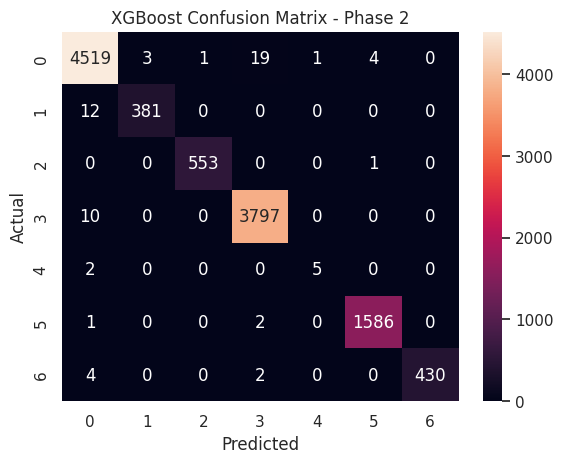

['phase2_xgboost_model.pkl']

In [50]:
xg2 = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, eval_metric='mlogloss')
xg2.fit(X_train_res, y_train_res)

y_pred_xg = xg2.predict(X_test_red)
xg2_score = xg2.score(X_test_red, y_test_red)
xg2_precision, xg2_recall, xg2_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_xg, average='weighted')

print("XGBoost Accuracy:", xg2_score)
print("XGBoost Precision:", xg2_precision)
print("XGBoost Recall:", xg2_recall)
print("XGBoost F1-score:", xg2_fscore)
print(classification_report(y_test_red, y_pred_xg))


cm = confusion_matrix(y_test_red, y_pred_xg)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('XGBoost Confusion Matrix - Phase 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('phase2_xgb_confusion_matrix.png')
plt.show()

joblib.dump(xg2, 'phase2_xgboost_model.pkl')


RF Accuracy: 0.9966469602047119
RF Precision: 0.9966458293546888
RF Recall: 0.9966469602047119
RF F1-score: 0.9966278606816129
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



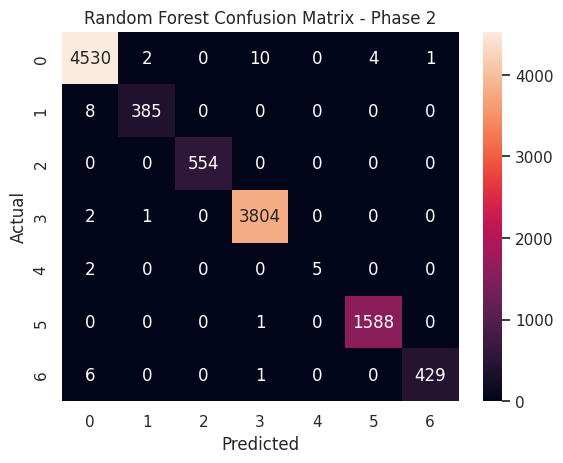

['phase2_random_forest_model.pkl']

In [51]:
rf2 = RandomForestClassifier(random_state=0)
rf2.fit(X_train_res, y_train_res)

y_pred_rf = rf2.predict(X_test_red)
rf2_score = rf2.score(X_test_red, y_test_red)
rf2_precision, rf2_recall, rf2_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_rf, average='weighted')

print("RF Accuracy:", rf2_score)
print("RF Precision:", rf2_precision)
print("RF Recall:", rf2_recall)
print("RF F1-score:", rf2_fscore)
print(classification_report(y_test_red, y_pred_rf))

cm = confusion_matrix(y_test_red, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix - Phase 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('phase2_rf_confusion_matrix.png')
plt.show()

joblib.dump(rf2, 'phase2_random_forest_model.pkl')


In [52]:
results_phase2 = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [dt2_score, rf2_score, xg2_score],
    'Precision': [dt2_precision, rf2_precision, xg2_precision],
    'Recall': [dt2_recall, rf2_recall, xg2_recall],
    'F1-score': [dt2_fscore, rf2_fscore, xg2_fscore]
}

df_results2 = pd.DataFrame(results_phase2)
df_results2.to_csv('model_results_phase2.csv', index=False)

**Phase - III: Ensemble**

In [53]:
#importing necessary libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [54]:
# Base models
estimators = [
    ('dt', dt2),
    ('rf', rf2),
    ('xgb', xg2)
]

# Meta-learner
meta_model = LogisticRegression(max_iter=1000)

# Stacking model
stacked_model = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)

In [55]:
#training the stacking classifier
stacked_model.fit(X_train_res, y_train_res)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:58:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:58:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:58:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=0)),
                               ('rf', RandomForestClassifier(random_state=0)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              fea...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=10, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(max_iter=1000))

Stacked Model Accuracy: 0.9972646254301597
Stacked Model Precision: 0.9972642453355733
Stacked Model Recall: 0.9972646254301597
Stacked Model F1-score: 0.9972468252662092
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



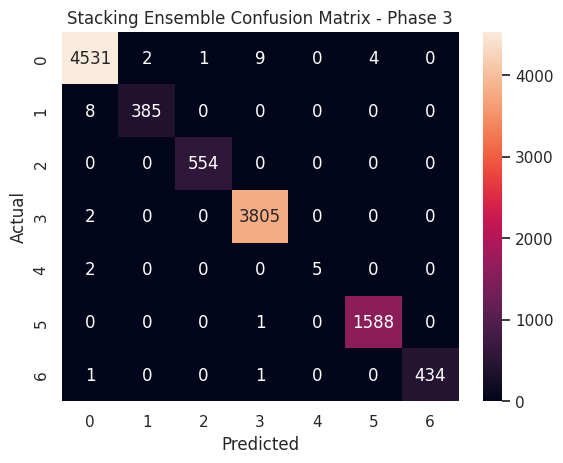

In [56]:
#evaluate on test data
y_pred_stack = stacked_model.predict(X_test_red)

stack_score = stacked_model.score(X_test_red, y_test_red)
stack_precision, stack_recall, stack_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_stack, average='weighted')

print("Stacked Model Accuracy:", stack_score)
print("Stacked Model Precision:", stack_precision)
print("Stacked Model Recall:", stack_recall)
print("Stacked Model F1-score:", stack_fscore)
print(classification_report(y_test_red, y_pred_stack))

cm = confusion_matrix(y_test_red, y_pred_stack)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Stacking Ensemble Confusion Matrix - Phase 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('phase3_stacking_confusion_matrix.png')
plt.show()

In [57]:
joblib.dump(stacked_model, 'stacking_ensemble_model.pkl')

['stacking_ensemble_model.pkl']

In [58]:
results_all = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'Stacked Ensemble'],
    'Accuracy': [dt2_score, rf2_score, xg2_score, stack_score],
    'Precision': [dt2_precision, rf2_precision, xg2_precision, stack_precision],
    'Recall': [dt2_recall, rf2_recall, xg2_recall, stack_recall],
    'F1-score': [dt2_fscore, rf2_fscore, xg2_fscore, stack_fscore]
}

df_final_results = pd.DataFrame(results_all)
df_final_results.to_csv('final_model_results.csv', index=False)

**ALL PHASE RESULT COMPARISON**

In [59]:
# Phase 1 results
results_phase1 = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [dt_score, rf_score, xg_score],
    'Precision': [dt_precision, rf_precision, xgb_precision],
    'Recall': [dt_recall, rf_recall, xgb_recall],
    'F1-score': [dt_fscore, rf_fscore, xgb_fscore],
    'Phase': ['Phase 1'] * 3
}

# Phase 2 results
results_phase2 = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [dt2_score, rf2_score, xg2_score],
    'Precision': [dt2_precision, rf2_precision, xg2_precision],
    'Recall': [dt2_recall, rf2_recall, xg2_recall],
    'F1-score': [dt2_fscore, rf2_fscore, xg2_fscore],
    'Phase': ['Phase 2'] * 3
}

# Create DataFrames
df_phase1 = pd.DataFrame(results_phase1)
df_phase2 = pd.DataFrame(results_phase2)

# Combine into final results
df_final = pd.concat([df_phase1, df_phase2], ignore_index=True)

# Save to CSV
df_final.to_csv('final_results.csv', index=False)

print("final_results.csv saved successfully!")

final_results.csv saved successfully!


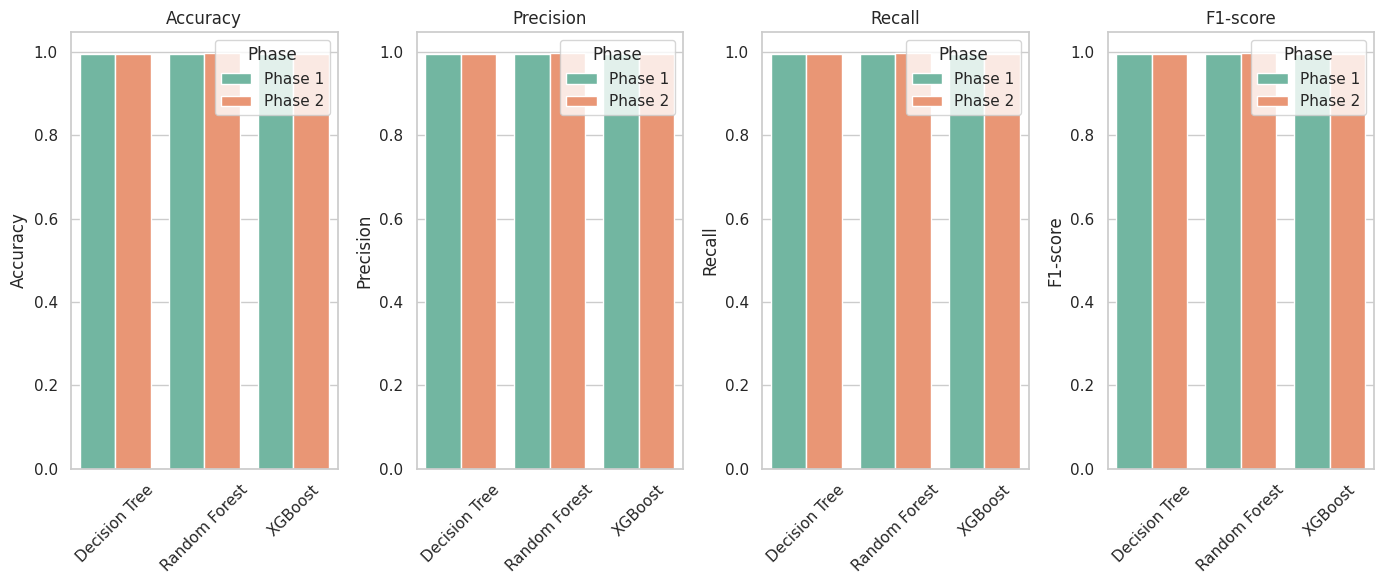

In [60]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i + 1)
    sns.barplot(x='Model', y=metric, hue='Phase', data=df_final, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel("")

plt.tight_layout()
plt.savefig('model_comparison_plots.png')
plt.show()

**Evaluate and Time Each Model**

In [61]:
import time

#decision tree
start_dt_train = time.time()
dt2.fit(X_train_res, y_train_res)
end_dt_train = time.time()

start_dt_pred = time.time()
y_pred_dt = dt2.predict(X_test_red)
end_dt_pred = time.time()


dt2_score = accuracy_score(y_test_red, y_pred_dt)
dt2_precision, dt2_recall, dt2_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_dt, average='weighted')


In [62]:
#random forest
start_rf_train = time.time()
rf2.fit(X_train_res, y_train_res)
end_rf_train = time.time()

start_rf_pred = time.time()
y_pred_rf = rf2.predict(X_test_red)
end_rf_pred = time.time()

rf2_score = accuracy_score(y_test_red, y_pred_rf)
rf2_precision, rf2_recall, rf2_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_rf, average='weighted')

In [63]:
# XGBoost
start_xg_train = time.time()
xg2.fit(X_train_res, y_train_res)
end_xg_train = time.time()

start_xg_pred = time.time()
y_pred_xg = xg2.predict(X_test_red)
end_xg_pred = time.time()

xg2_score = accuracy_score(y_test_red, y_pred_xg)
xg2_precision, xg2_recall, xg2_fscore, _ = precision_recall_fscore_support(y_test_red, y_pred_xg, average='weighted')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:09:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [64]:
results_with_time = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [dt2_score, rf2_score, xg2_score],
    'Precision': [dt2_precision, rf2_precision, xg2_precision],
    'Recall': [dt2_recall, rf2_recall, xg2_recall],
    'F1-score': [dt2_fscore, rf2_fscore, xg2_fscore],
    'Training Time (s)': [
        end_dt_train - start_dt_train,
        end_rf_train - start_rf_train,
        end_xg_train - start_xg_train
    ],
    'Prediction Time (s)': [
        end_dt_pred - start_dt_pred,
        end_rf_pred - start_rf_pred,
        end_xg_pred - start_xg_pred
    ]
}

df_time_results = pd.DataFrame(results_with_time)
df_time_results.to_csv('model_results_with_time.csv', index=False)

print("Saved to model_results_with_time.csv")

Saved to model_results_with_time.csv
